# **N07. ROBUST CLASSIFICATION**

In this notebook, we perform a robust classification for labeling detected objects.

In [1]:
import pickle
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import gc
import numpy as np
import os 
import libraries.object_classification as oc
gc.collect()
#!pip install "numpy>=2.0,<2.3" --upgrade

0

## Load database

Load the databases and the keys.

In [2]:
# Load folder path.
FOLDER_FITS = "resources/database/fits_db"
FOLDER_DB = "resources/database/raw_db"
# Load databases.
data_1 = "fits_files1.pkl"
data_2 = "fits_files2.pkl"
database_1 = "psf_metadata1.db"
database_2 = "psf_metadata2.db"

# Load headers.
HEADERS_ORIGNAL = "resources/metis_all25022025151324.pkl"

In [3]:
# Load fits files.
fits_1 = pd.read_pickle(os.path.join(FOLDER_FITS, data_1))
fits_2 = pd.read_pickle(os.path.join(FOLDER_FITS, data_2))

In order to make easy work, just work with the files with the higher resolution.

In [4]:
# Load original fits.
original_fits = pd.DataFrame(pd.read_pickle(HEADERS_ORIGNAL))[["filename", "width", "url"]]
original_fits = original_fits.rename(columns={"filename": "FILENAME"})

Add this label into the fits files downloaded.

In [5]:
fits_1 = pd.merge(fits_1, original_fits, on="FILENAME", how="inner")
fits_2 = pd.merge(fits_2, original_fits, on="FILENAME", how="inner")

Keep files with highest resolution (original size equal to actual size).

In [6]:
fits_1["binning"] = fits_1["width"].apply(
    lambda x: 1 if x == 2048.0 else (2 if x == 1024.0 else (4 if x == 512.0 else None))
)
fits_1 = fits_1[["FILENAME", "binning"]]

fits_2["binning"] = fits_2["width"].apply(
    lambda x: 1 if x == 2048.0 else (2 if x == 1024.0 else (4 if x == 512.0 else None))
)
fits_2 = fits_2[["FILENAME", "binning"]]

Load data and extract just possible objects.

In [7]:
# Load from SQLite.
conn = sqlite3.connect(os.path.join(FOLDER_DB, database_1))
possible_objects = pd.read_sql("SELECT * FROM psfs", conn)

# Convert REGION back into numpy arrays
possible_objects["REGION"] = possible_objects["REGION"].apply(pickle.loads)

# Extract objects.
#possible_objects = possible_objects[possible_objects["PRE_LABEL"] == "object"]

# Extract stars
possible_stars = possible_objects[possible_objects["PRE_LABEL"] == "star"]


Extract stars.

In [ ]:
possible_stars = pd.merge(possible_stars, fits_1, on = "FILENAME", how = "inner")
stars_1 = possible_stars[possible_stars["binning"] == 1]
print(f"Number of objects with highest quality: {len(stars_1)}")
stars_1.to_pickle("resources/database/stars_db/stars.pkl")

Number of objects with highest quality: 20307


Add binning factor.

In [12]:
possible_objects = pd.merge(possible_objects, fits_1, on = "FILENAME", how = "inner")
dataset_1 = possible_objects[possible_objects["binning"] == 1]
print(f"Number of objects with highest quality: {len(dataset_1)}")

Number of objects with highest quality: 99412


In [13]:
possible_objects = None
gc.collect()

0

## 1. Create new features.

### 1.1 Normalization and cropping.

First, apply normalization and croping to the images.

In [ ]:
def crop_psf(image, size = 25):
    """Convert image into small size."""
    return (image[size:-size, size:-size])

def normalize_psf(image):
    """Normalize image to 0-1 range"""
    return (image - np.min(image))/(np.max(image) - np.min(image))


# Apply cropping.
dataset_1["img_norm"] = dataset_1["REGION"].apply(lambda x: crop_psf(x))

# Apply normalization.
dataset_1["img_norm"] = dataset_1["img_norm"].apply(lambda x: normalize_psf(x))


Check if normalization was done successfully.

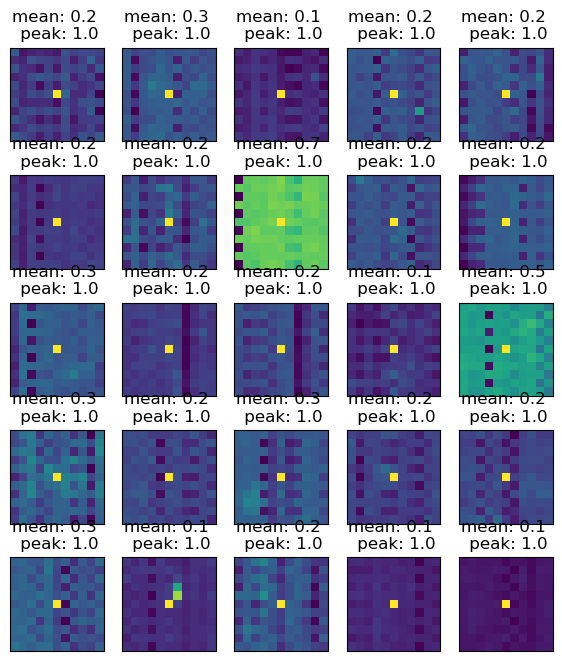

In [11]:
fig, axis = plt.subplots(5, 5, figsize = (7, 8))
axis = axis.flatten()

samples = dataset_1.sample(25)["img_norm"]

for i, img in enumerate(samples):
    img_s = samples.iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img_s)
    axis[i].set_title(f"mean: {np.round(np.mean(img_s), 1)} \n peak: {np.round(img_s[5,5], 2)}")

### 1.2 Clean holes in image due to broken columns.

After normalization, we still see some holes in the images. For the classification techniques we want to aply, this could complicate all the algorithm. Then we need to fix this by applying a smothing.

In [12]:
def find_patches(img):

    # Define threshold.
    thrs = np.median(img)
    X = []
    Y = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] < thrs:
                X.append(i)
                Y.append(j)
    return [X,Y]


def patch_pixels_flexible(img, X, Y):

    h, w = img.shape

    for i, j in zip(X, Y):
        # Define patch bounds, clipping to valid image range
        i_min = max(i - 1, 0)
        i_max = min(i + 2, h)
        j_min = max(j - 1, 0)
        j_max = min(j + 2, w)

        patch = img[i_min:i_max, j_min:j_max]
        
        # Flatten and remove the center if it's in bounds
        flat = patch.flatten()

        center_i = i - i_min
        center_j = j - j_min
        center_idx = center_i * patch.shape[1] + center_j

        if 0 <= center_idx < flat.size:
            neighbors = np.delete(flat, center_idx)
        else:
            neighbors = flat

        img[i, j] = np.mean(neighbors)

    return img

def removing_patches(img):
    """Compute points with value less than the median and apply smoothing"""
    x, y = find_patches(img)

    return patch_pixels_flexible(img, x, y)

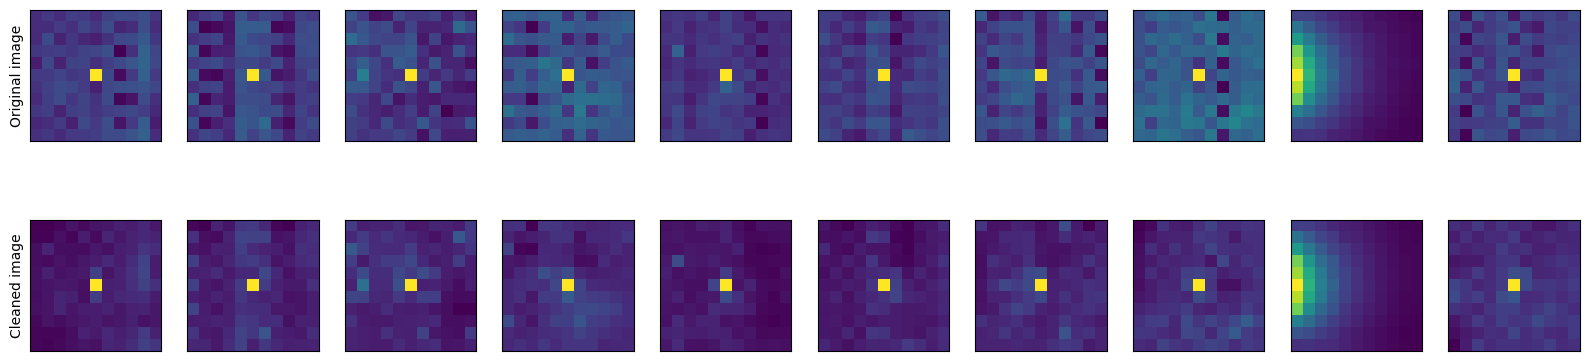

In [13]:
sample = dataset_1.sample(10)["img_norm"]
# Define axis labels.

fig, axis = plt.subplots(2, 10, figsize =(20, 5))

# Comparison before and after cleaning.
for i in range(10):
    img = sample.iloc[i]
    axis[0][i].set_xticks([]), axis[0][i].set_yticks([])
    axis[0][i].imshow(img)
    # Take patches.
    patches = find_patches(img)
    img_cleaned = patch_pixels_flexible(img, patches[0], patches[1])
    axis[1][i].set_xticks([]), axis[1][i].set_yticks([])
    axis[1][i].imshow(img_cleaned)
    axis[0,0].set_ylabel("Original image")
    axis[1,0].set_ylabel("Cleaned image")
    

Apply this cleaning to all images.

In [14]:
dataset_1["img_norm"] = dataset_1["img_norm"].apply(lambda x: removing_patches(x))
dataset_1["img_norm"] = dataset_1["img_norm"].apply(lambda x: normalize_psf(x))

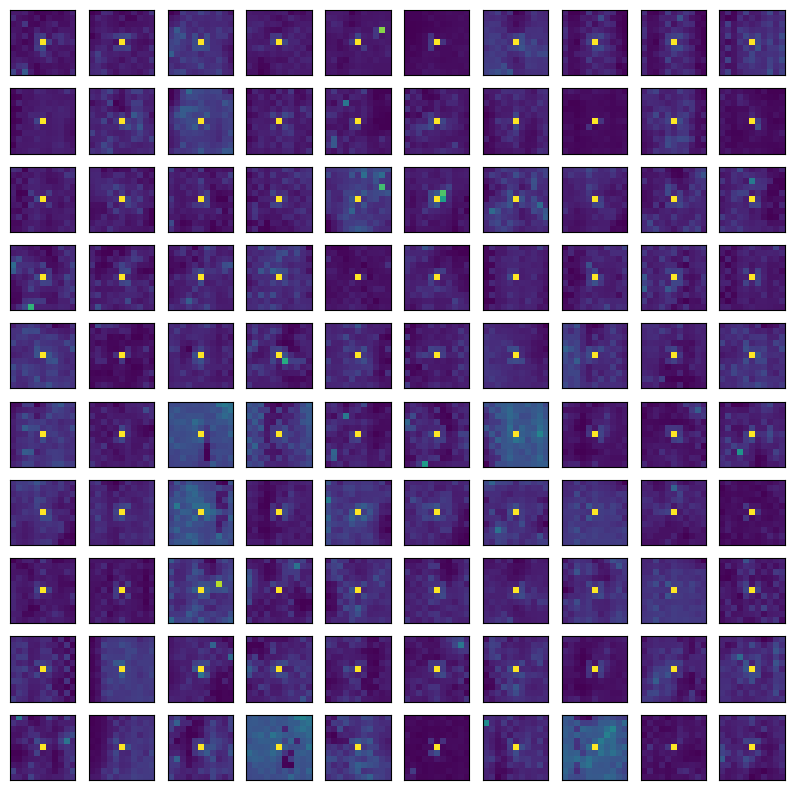

In [15]:
# Visualize samples.
means = []
sample = dataset_1.sample(100)["img_norm"]
# Define axis labels.

fig, axis = plt.subplots(10, 10, figsize =(10, 10))
axis = axis.flatten()

# Comparison before and after cleaning.
for i in range(100):
    img = sample.iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)
    means.append(np.mean(img))

### 1.3. Remove broken images.

For removing these images, we will compute the mean of the images.

Text(0, 0.5, 'Number of images')

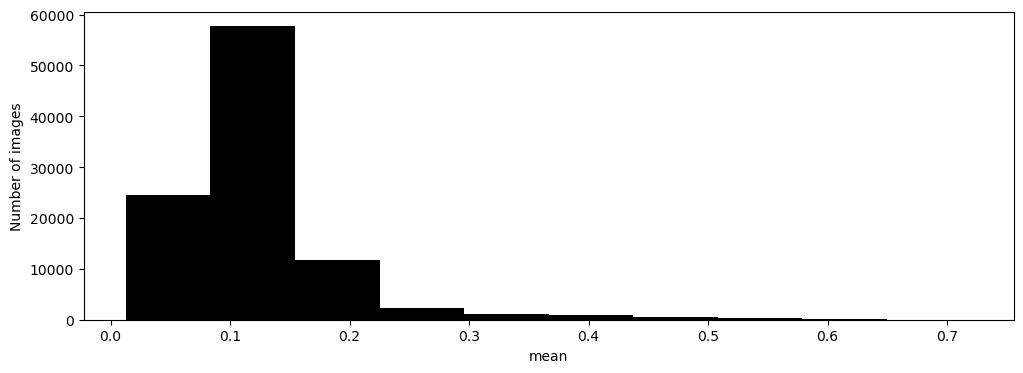

In [16]:
means = []
for i in range(len(dataset_1)):
    means.append(np.mean(dataset_1["img_norm"].iloc[i]))

fig, axis = plt.subplots(1, 1, figsize = (12, 4))
axis.hist(means, color= "black")
axis.set_xlabel("mean")
axis.set_ylabel("Number of images")

In [17]:
dataset_1["mean"] = dataset_1["img_norm"].apply(lambda x: np.mean(x))
dataset_1["std"] = dataset_1["img_norm"].apply(lambda x: np.std(x))

Text(0, 0.5, 'Number of images')

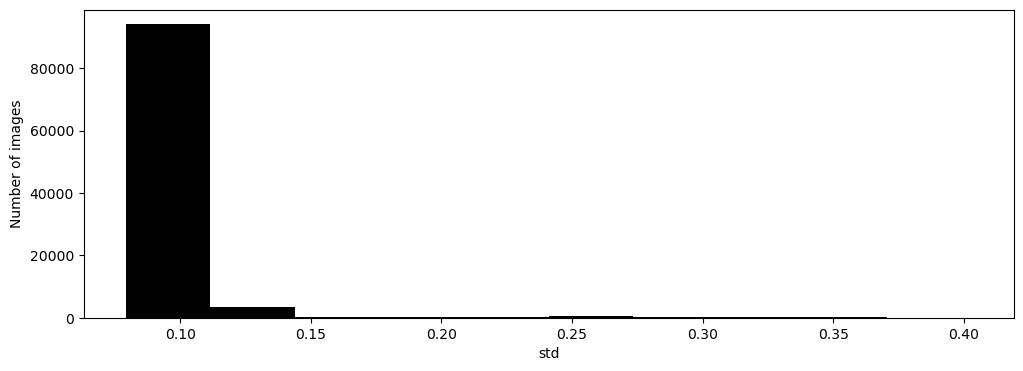

In [18]:
fig, axis = plt.subplots(1, 1, figsize = (12, 4))
axis.hist(dataset_1["std"].to_list(), color= "black")
axis.set_xlabel("std")
axis.set_ylabel("Number of images")

Size of samples: 970


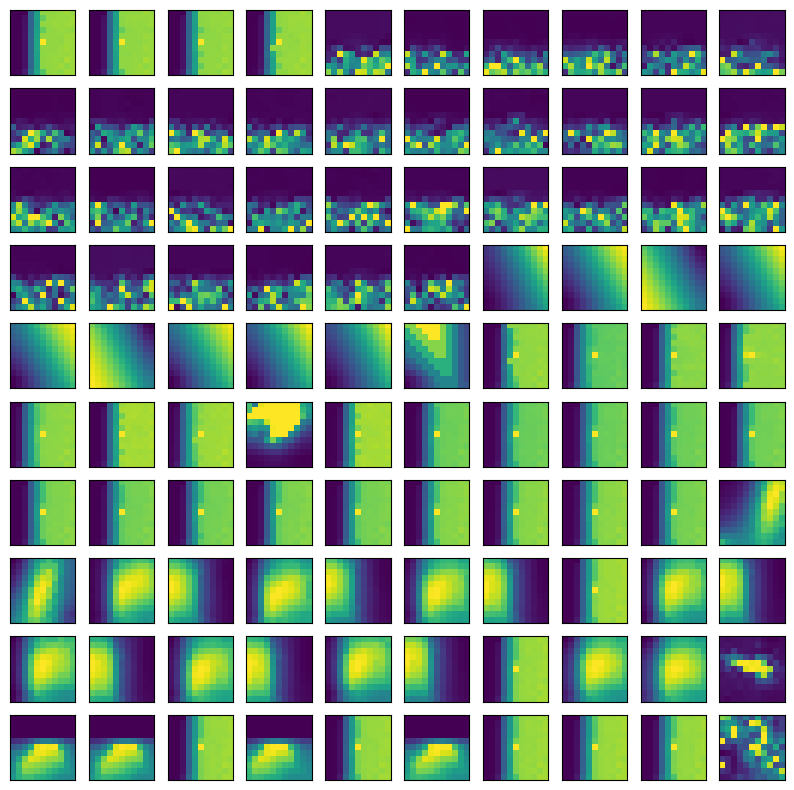

In [19]:
fig, axis = plt.subplots(10, 10, figsize =(10, 10))
axis = axis.flatten()
samples = dataset_1[dataset_1["std"]>0.25]["img_norm"]
print(f"Size of samples: {len(samples)}")
# Comparison before and after cleaning.
for i in range(100):
    img = samples.iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)
    means.append(np.mean(img))

Size of samples: 359


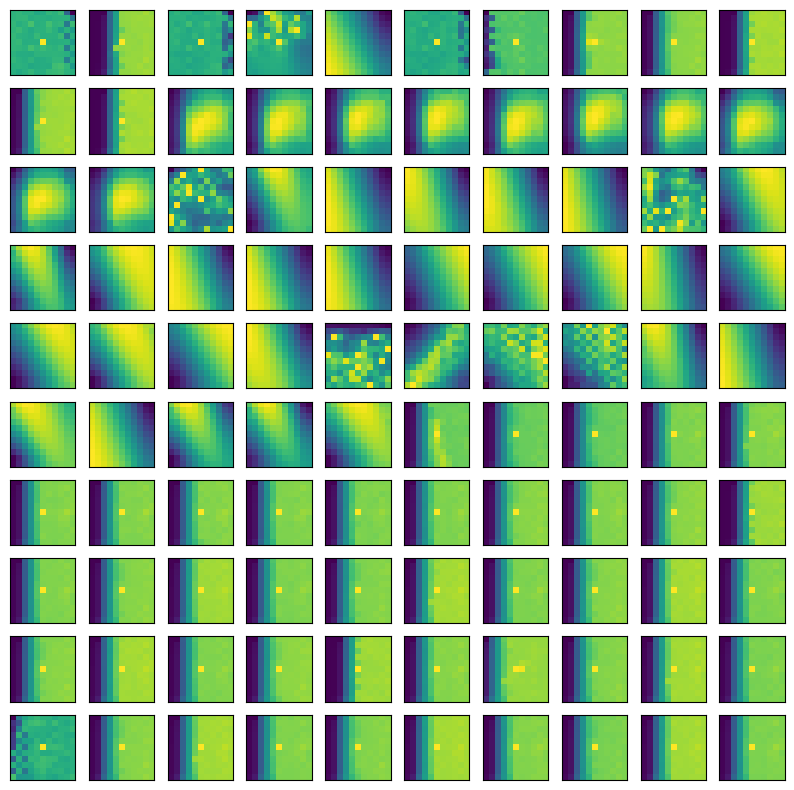

In [20]:
fig, axis = plt.subplots(10, 10, figsize =(10, 10))
axis = axis.flatten()
samples = dataset_1[dataset_1["mean"]>0.55]
print(f"Size of samples: {len(samples)}")
# Comparison before and after cleaning.
for i in range(100):
    img = samples["img_norm"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)
    means.append(np.mean(img))

**Retrieve a pair of examples**

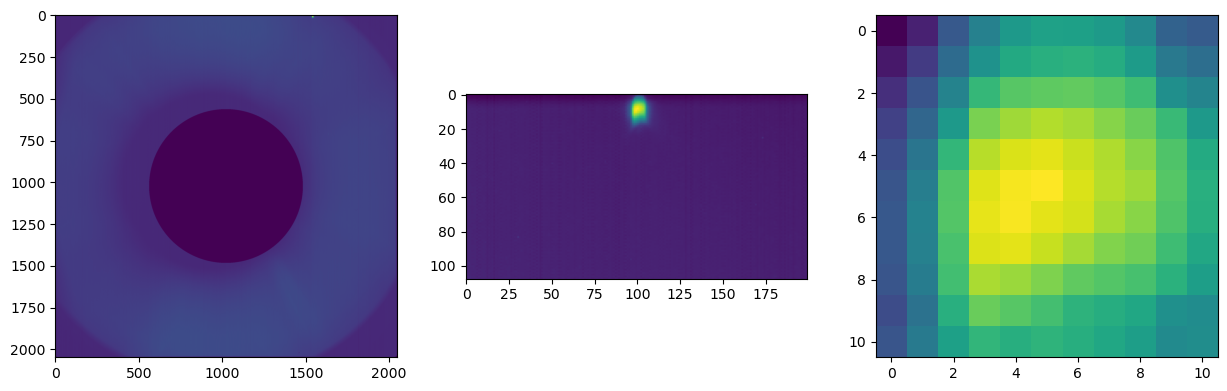

In [21]:
import libraries.utilities as ut
from astropy.io import fits

# Take a sample image.
img = samples.iloc[19]
filename_test = img["FILENAME"]
x, y =img[["X_COORD", "Y_COORD"]]


# Retrieve url.
url = original_fits[original_fits["FILENAME"] == filename_test]["url"].iloc[0]

# Download image.
ut.download_fits(url, "fits_test_1.fits", "resources")

# Open image.
image = fits.open(os.path.join("resources", "fits_test_1.fits"))[0].data

fig, axis = plt.subplots(1, 3, figsize = (15, 5))

axis[0].imshow(image)
axis[1].imshow(image[y-8:y+100, x-100:x+100])

axis[2].imshow(img["img_norm"])

### 1.4. Compute neighbors

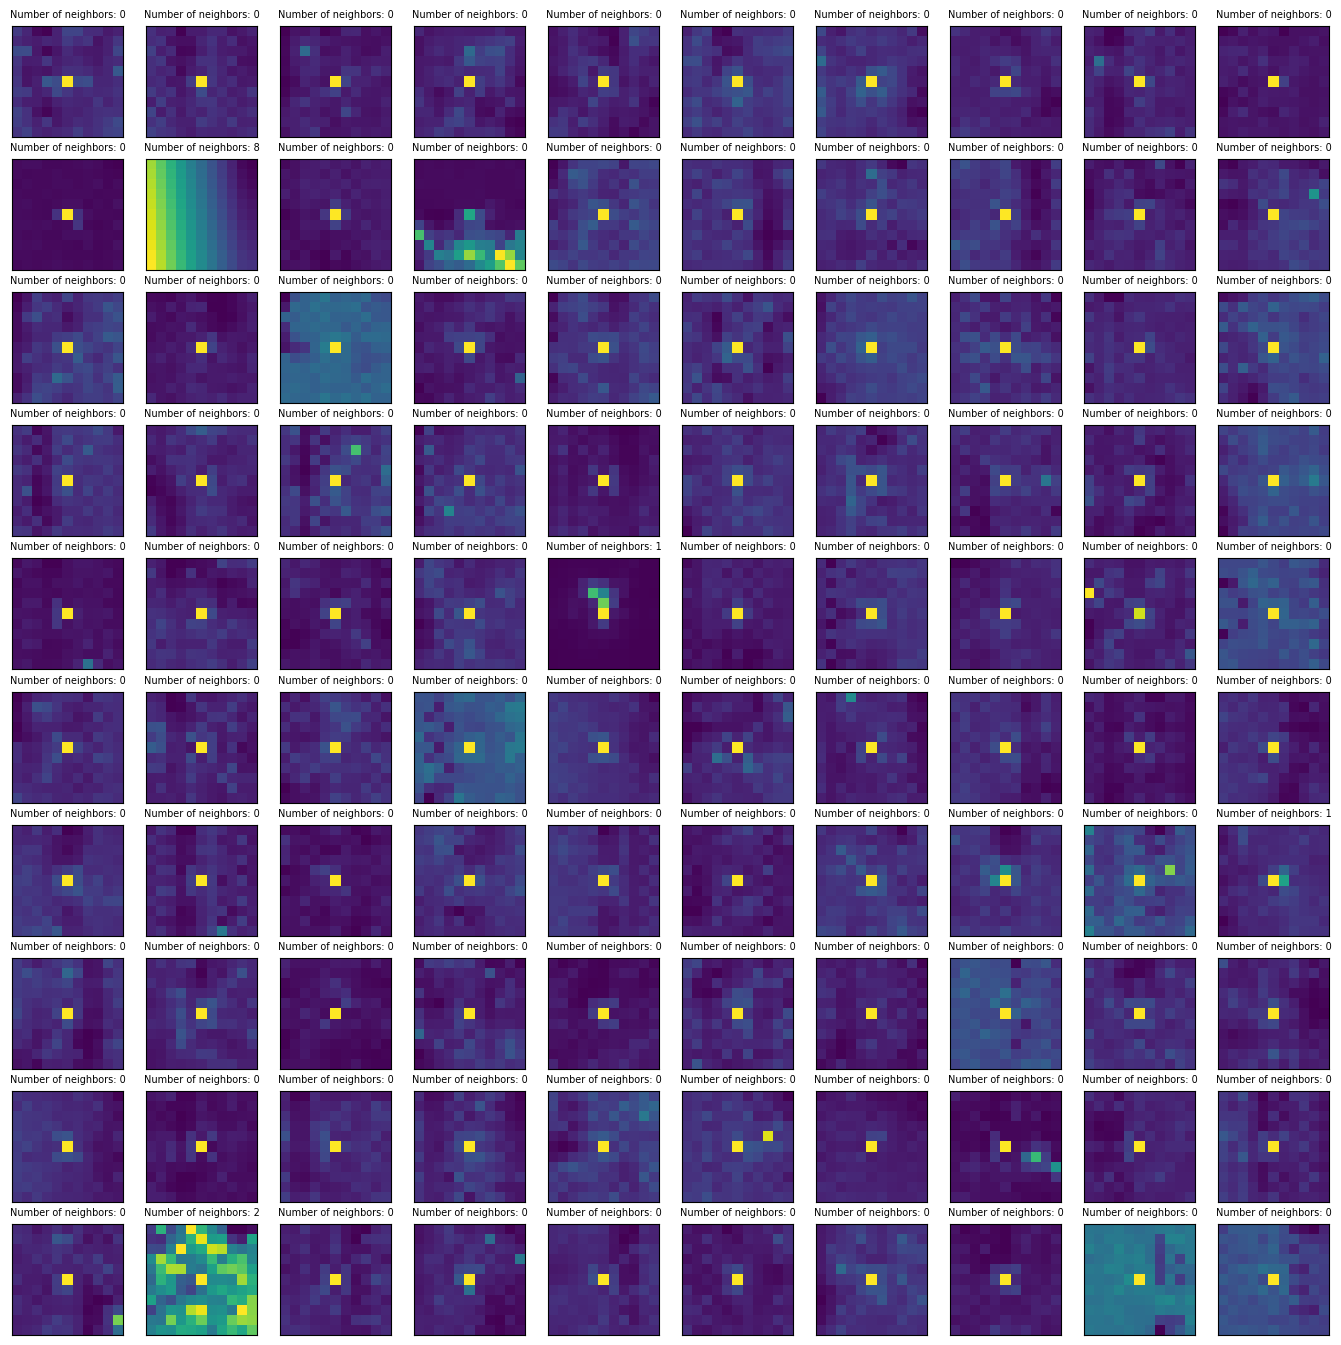

In [22]:
def detect_neighbors(img, threshold = 0.5, center = [5,5]):

    x, y = center
    peak = img[x,y]*threshold

    img = img[4:-4, 4:-4]
    min_values = img[img > peak]
    return len(min_values) -1

sample = dataset_1.sample(100)

fig, axis = plt.subplots(10, 10, figsize = (17,17))
axis = axis.flatten()
for i in range(100):
    img = sample["img_norm"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)
    n_samples = detect_neighbors(img)
    axis[i].set_title(f"Number of neighbors: {n_samples}", fontsize = 7)

### 1.5. Check center

In [23]:
def check_center(img, center = [5,5]):
    x, y = center
    if img[x,y] == 1.0:
        return True
    
    else:
        return False

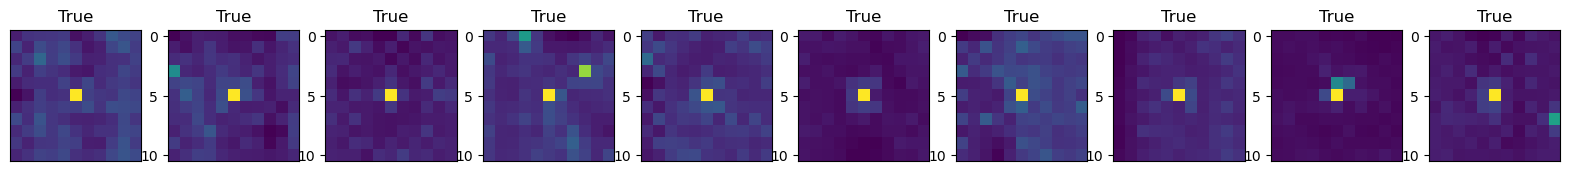

In [24]:
sample = dataset_1.sample(10)["img_norm"]
# Define axis labels.

fig, axis = plt.subplots(1, 10, figsize =(20, 5))

# Comparison before and after cleaning.
for i in range(10):
    img = sample.iloc[i]
    axis[i].set_xticks([]), axis[0].set_yticks([])
    axis[i].imshow(img)
    value = check_center(img)
    axis[i].set_title(f"{value}")


### 1.6. Detect broken images

In [25]:
def detect_broken_image(img):

    img_left = img[:30,:]
    img_right = img[30:, :]
    mean_l = np.mean(img_left)
    mean_r = np.mean(img_right)

    if mean_l>mean_r:
        ratio_1 = mean_r/mean_l
    else:
        ratio_1 = mean_l/mean_r
    
    img_up = img[:,:30]
    img_down = img[:, 30:]
    mean_u = np.mean(img_up)
    mean_d = np.mean(img_down)

    if mean_u>mean_d:
        ratio_2 = mean_d/mean_u
    else:
        ratio_2 = mean_u/mean_d
    
    return np.min([ratio_1, ratio_2])


In [140]:
import numpy as np

def compute_center_of_mass(image, threshold=0.8):
    """
    Compute the intensity-weighted center of mass of bright pixels.

    Parameters:
        image (2D np.array): Input image with values from 0 to 1.
        threshold (float): Pixels above this value are considered bright.

    Returns:
        (float, float): (y_center, x_center)
    """
    bright_mask = image > threshold
    if not np.any(bright_mask):
        return None  # No bright pixels

    y_indices, x_indices = np.nonzero(bright_mask)
    intensities = image[bright_mask]

    total_intensity = np.sum(intensities)
    y_com = np.sum(y_indices * intensities) / total_intensity
    x_com = np.sum(x_indices * intensities) / total_intensity

    return y_com, x_com

a, b = compute_center_of_mass(img)

## 2. Build Catalogue (Manual)

Here we will apply all our functions to clean the dataset.

In [26]:
# Restart dataset.

# Apply cropping.
dataset_1["img_norm"] = dataset_1["REGION"].apply(lambda x: crop_psf(x, size = 25))

# Apply normalization.
dataset_1["img_norm"] = dataset_1["img_norm"].apply(lambda x: normalize_psf(x))
# Apply patching.
dataset_1["img_norm"] = dataset_1["img_norm"].apply(lambda x: removing_patches(x))

# Apply normalization.
dataset_1["img_norm"] = dataset_1["img_norm"].apply(lambda x: normalize_psf(x))

# Detect number of neighbors.
dataset_1["n_neighbors"] = dataset_1["img_norm"].apply(lambda x: detect_neighbors(x, threshold=0.8))

# Detect if main pixel is True.
dataset_1["main_pixel"] = dataset_1["img_norm"].apply(lambda x: check_center(x))

# Detect if image is broken.
dataset_1["broken_image_ratio"] = dataset_1["REGION"].apply(lambda x: detect_broken_image(x))



**Bright pixels**

Number of samples in this class: 97442


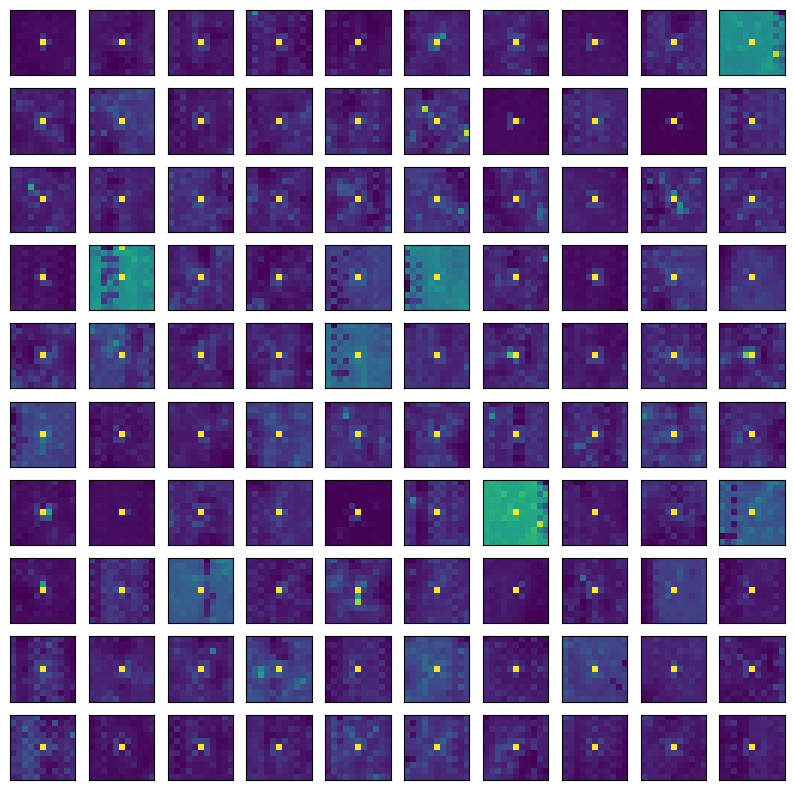

In [27]:
##### BRIGHT PIXELS WITH NO BACKGROUND ####
bright_pixels_no_background = dataset_1[dataset_1["n_neighbors"] == 0]
print(f"Number of samples in this class: {len(bright_pixels_no_background)}")

sample = bright_pixels_no_background.sample(100)
fig, axis = plt.subplots(10, 10, figsize = (10,10))
axis = axis.flatten()
for i in range(100):
    img = sample["img_norm"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)

In [33]:
new_objects = dataset_1[dataset_1["n_neighbors"]!= 0]
print(f"Number of samples in this class: {len(new_objects)}")

Number of samples in this class: 1970


**Uncentered images**

Number of samples in this class: 467


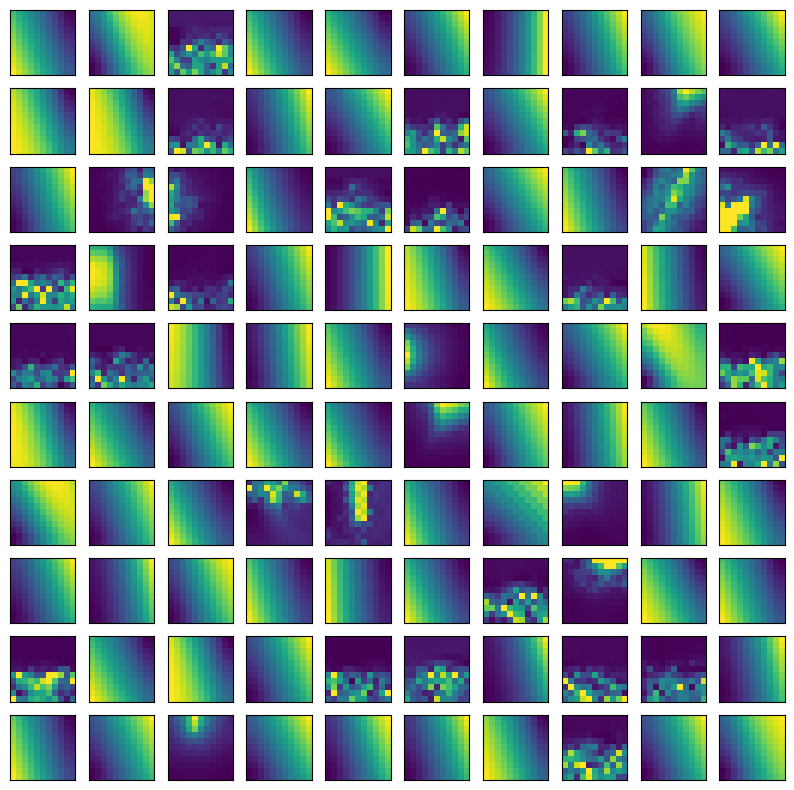

In [34]:
##### UNCENTERED IMAGES ####
uncentered_images = new_objects[new_objects["main_pixel"] == False]
print(f"Number of samples in this class: {len(uncentered_images)}")

sample = uncentered_images.sample(100)
fig, axis = plt.subplots(10, 10, figsize = (10,10))
axis = axis.flatten()
for i in range(100):
    img = sample["img_norm"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)


In [35]:
new_objects = new_objects[new_objects["main_pixel"]== True]
print(f"Number of samples in this class: {len(new_objects)}")

Number of samples in this class: 1503


**Broken images**

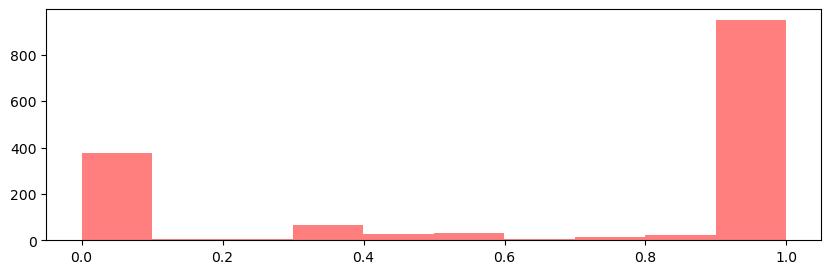

In [49]:

# Show histogram.
fig, axis = plt.subplots(1, 1, figsize = (10, 3))

a = axis.hist(new_objects["broken_image_ratio"].to_list(), color ="red", alpha = 0.5)

Number of samples in this class: 32


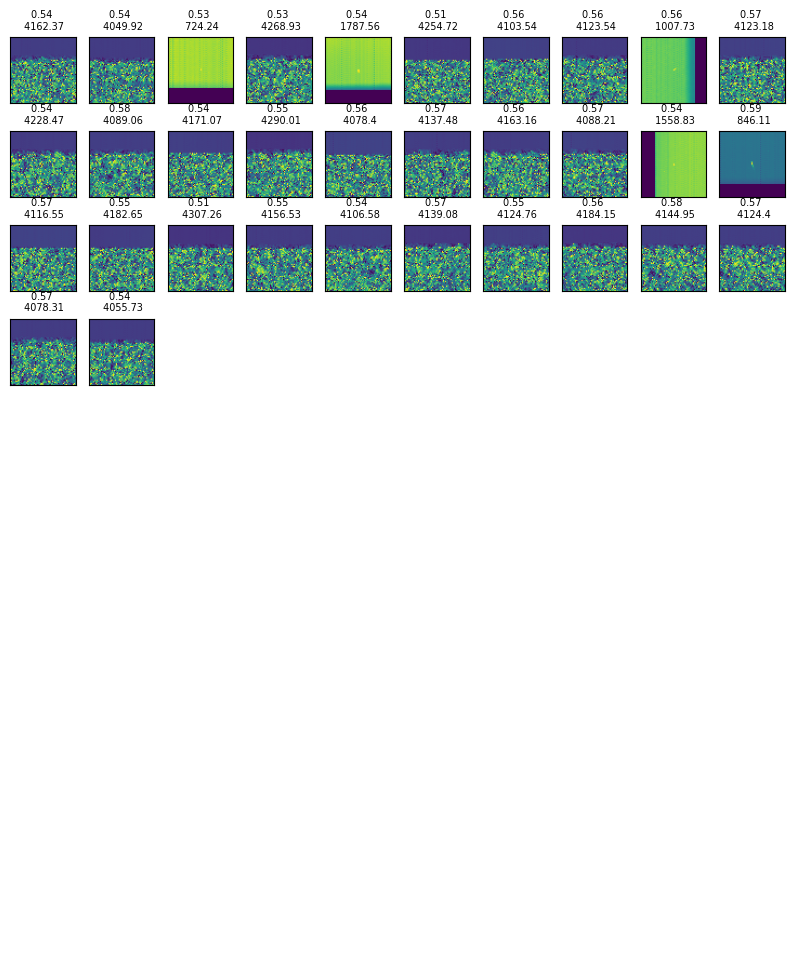

In [52]:
##### UNCENTERED IMAGES ####
broken_images = new_objects[(new_objects["broken_image_ratio"] <0.6) & (new_objects["broken_image_ratio"] >0.5)]
print(f"Number of samples in this class: {len(broken_images)}")
size = len(broken_images)
sample = broken_images.sample(size)
fig, axis = plt.subplots(10, 10, figsize = (10,12))
axis = axis.flatten()
for i in range(100):
    if i < size:
        std = np.round(sample["std"].iloc[i], 2)
        img = sample["REGION"].iloc[i]
        axis[i].set_xticks([]), axis[i].set_yticks([])
        axis[i].imshow(img)
        axis[i].set_title(f"{np.round(sample['broken_image_ratio'].iloc[i], 2)} \n {std}", fontsize = 7)
    else:
        axis[i].axis("off")


Number of samples in this class: 14


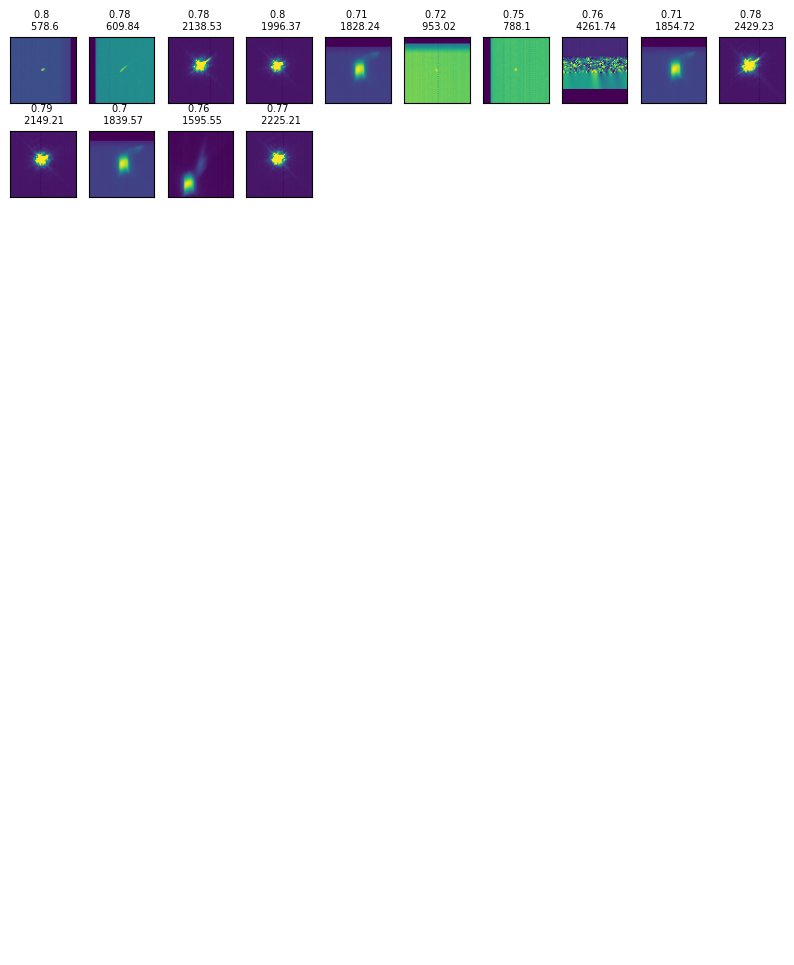

In [56]:
##### UNCENTERED IMAGES ####
broken_images = new_objects[(new_objects["broken_image_ratio"] <0.8) & (new_objects["broken_image_ratio"] >0.7)]
print(f"Number of samples in this class: {len(broken_images)}")
size = len(broken_images)
sample = broken_images.sample(size)
fig, axis = plt.subplots(10, 10, figsize = (10,12))
axis = axis.flatten()
for i in range(100):
    if i < size:
        std = np.round(sample["std"].iloc[i], 2)
        img = sample["REGION"].iloc[i]
        axis[i].set_xticks([]), axis[i].set_yticks([])
        axis[i].imshow(img)
        axis[i].set_title(f"{np.round(sample['broken_image_ratio'].iloc[i], 2)} \n {std}", fontsize = 7)
    else:
        axis[i].axis("off")


Number of samples in this class: 24


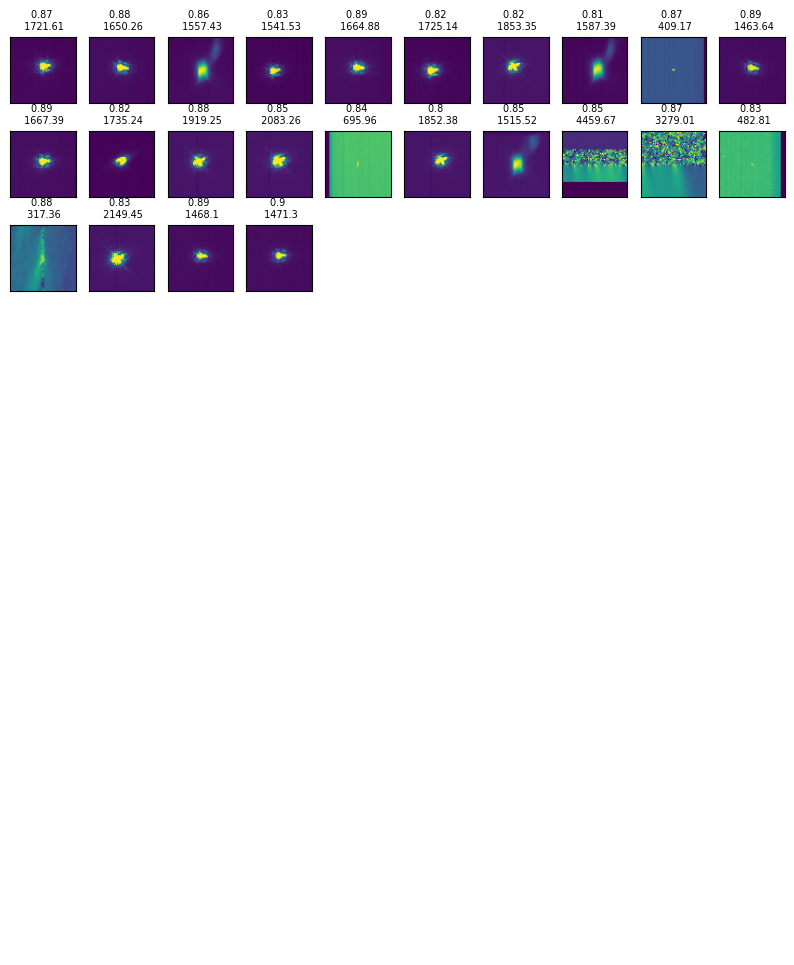

In [57]:
##### UNCENTERED IMAGES ####
broken_images = new_objects[(new_objects["broken_image_ratio"] <0.9) & (new_objects["broken_image_ratio"] >0.8)]
print(f"Number of samples in this class: {len(broken_images)}")
size = len(broken_images)
sample = broken_images.sample(size)
fig, axis = plt.subplots(10, 10, figsize = (10,12))
axis = axis.flatten()
for i in range(100):
    if i < size:
        std = np.round(sample["std"].iloc[i], 2)
        img = sample["REGION"].iloc[i]
        axis[i].set_xticks([]), axis[i].set_yticks([])
        axis[i].imshow(img)
        axis[i].set_title(f"{np.round(sample['broken_image_ratio'].iloc[i], 2)} \n {std}", fontsize = 7)
    else:
        axis[i].axis("off")


In [58]:
broken_images = new_objects[new_objects["broken_image_ratio"] <=0.6]
print(f"Number of samples: {len(broken_images)}")

Number of samples: 512


In [60]:
new_objects = new_objects[new_objects["broken_image_ratio"] >0.6]
print(f"Number of samples: {len(new_objects)}")

Number of samples: 991


**Remove difussive images**

Text(0, 0.5, 'number of samples')

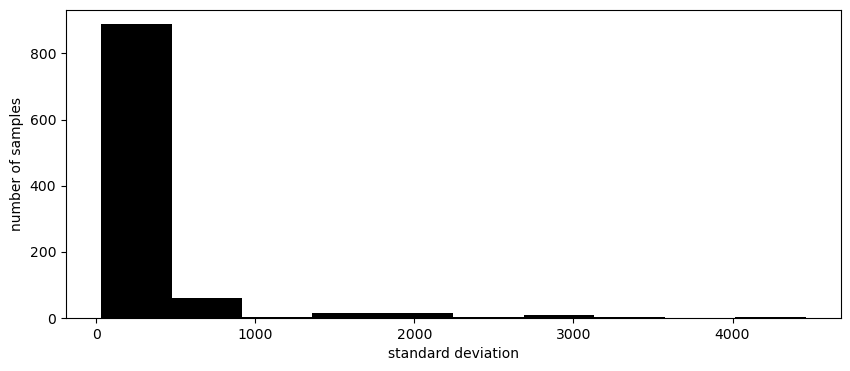

In [62]:
new_objects["std_r"] = new_objects["REGION"].apply(lambda x: np.std(x))

fig, axis = plt.subplots(1, 1, figsize = (10, 4))
a = axis.hist(new_objects["std"].to_list(), color = "black")
axis.set_xlabel("standard deviation")
axis.set_ylabel("number of samples")

Number of samples in this class: 43


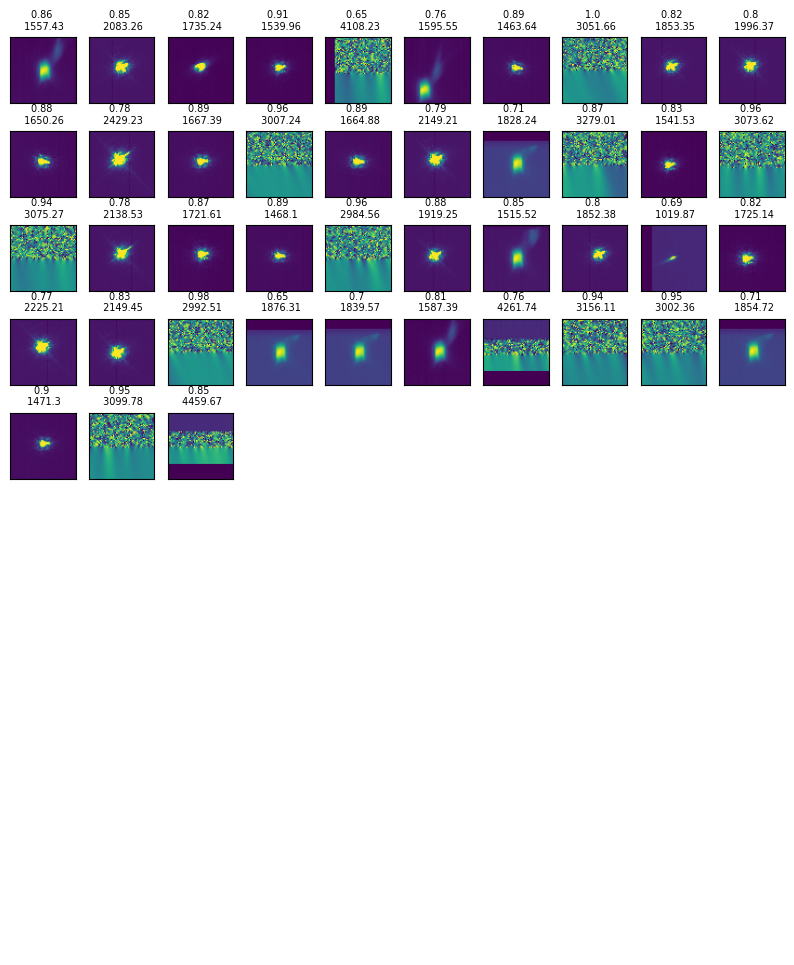

In [64]:
##### UNCENTERED IMAGES ####
difussive_objects = new_objects[(new_objects["std"] > 1000)]
print(f"Number of samples in this class: {len(difussive_objects)}")
size = len(difussive_objects)
sample = difussive_objects.sample(size)
fig, axis = plt.subplots(10, 10, figsize = (10,12))
axis = axis.flatten()
for i in range(100):
    if i < size:
        std = np.round(sample["std"].iloc[i], 2)
        img = sample["REGION"].iloc[i]
        axis[i].set_xticks([]), axis[i].set_yticks([])
        axis[i].imshow(img)
        axis[i].set_title(f"{np.round(sample['broken_image_ratio'].iloc[i], 2)} \n {std}", fontsize = 7)
    else:
        axis[i].axis("off")


Number of samples in this class: 948


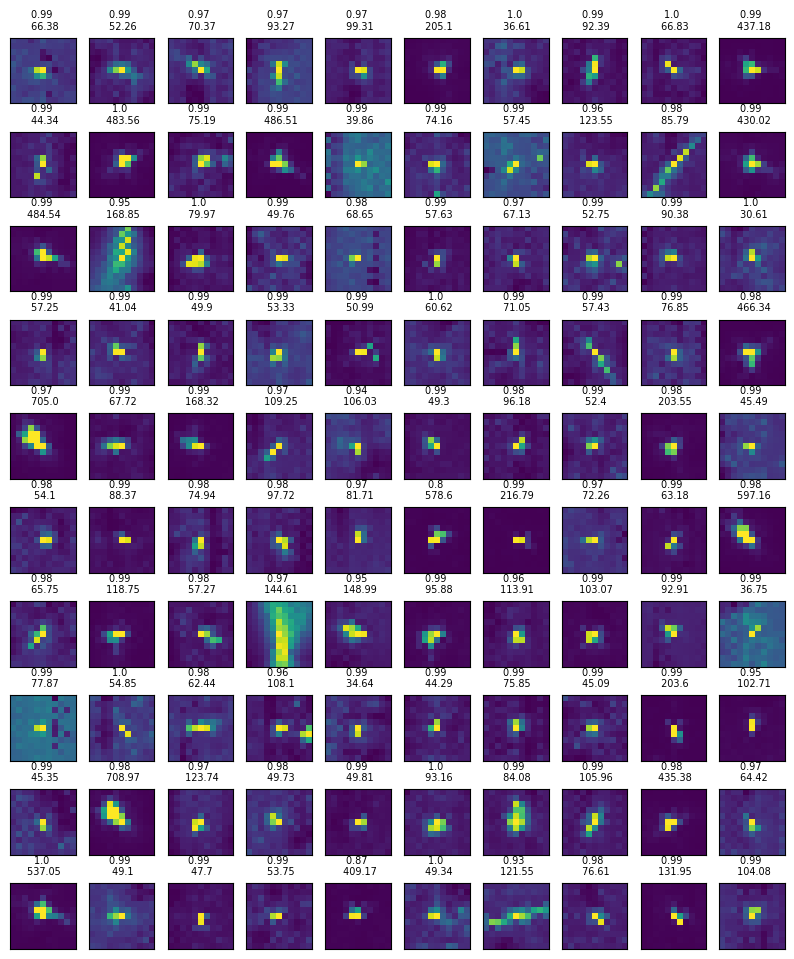

In [70]:
##### UNCENTERED IMAGES ####
difussive_objects = new_objects[(new_objects["std"] < 1000)]
print(f"Number of samples in this class: {len(difussive_objects)}")
size = len(difussive_objects)
sample = difussive_objects.sample(size)
fig, axis = plt.subplots(10, 10, figsize = (10,12))
axis = axis.flatten()
for i in range(100):
    if i < size:
        std = np.round(sample["std"].iloc[i], 2)
        img = sample["img_norm"].iloc[i]
        axis[i].set_xticks([]), axis[i].set_yticks([])
        axis[i].imshow(img)
        axis[i].set_title(f"{np.round(sample['broken_image_ratio'].iloc[i], 2)} \n {std}", fontsize = 7)
    else:
        axis[i].axis("off")


Number of samples in this class: 24


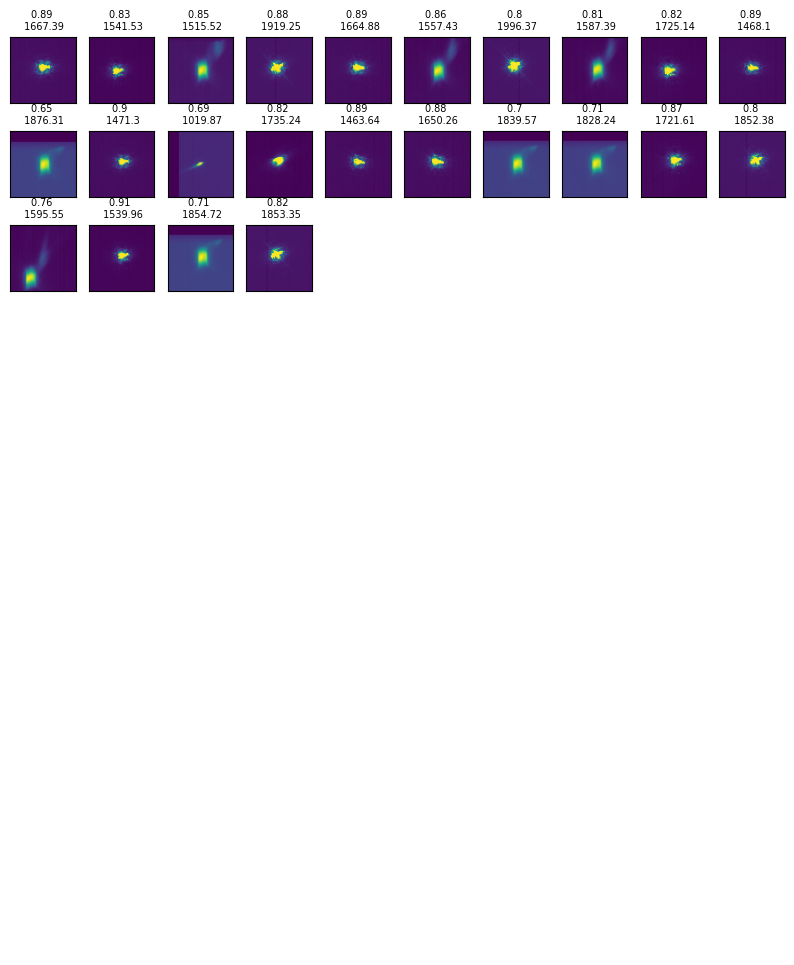

In [68]:
##### UNCENTERED IMAGES ####
difussive_objects = new_objects[(new_objects["std"] > 1000) & (new_objects["std"] < 2000)]
print(f"Number of samples in this class: {len(difussive_objects)}")
size = len(difussive_objects)
sample = difussive_objects.sample(size)
fig, axis = plt.subplots(10, 10, figsize = (10,12))
axis = axis.flatten()
for i in range(100):
    if i < size:
        std = np.round(sample["std"].iloc[i], 2)
        img = sample["REGION"].iloc[i]
        axis[i].set_xticks([]), axis[i].set_yticks([])
        axis[i].imshow(img)
        axis[i].set_title(f"{np.round(sample['broken_image_ratio'].iloc[i], 2)} \n {std}", fontsize = 7)
    else:
        axis[i].axis("off")


In [66]:
new_objects = new_objects[new_objects["std_r"] < 2000]
print(f"size of the population:{len(new_objects)}")

size of the population:972


## 3. Automatic classification

**Try with subset 2**

In [3]:
# Load folder path.
FOLDER = "resources/database"
data_2 = "fits_files2.pkl"
database_2 = "psf_metadata2.db"
HEADERS_ORIGNAL = "resources/metis_all25022025151324.pkl"
fits_2 = pd.read_pickle(os.path.join(FOLDER, data_2))

In [4]:
# Load original fits.
original_fits = pd.DataFrame(pd.read_pickle(HEADERS_ORIGNAL))[["filename", "width", "url"]]
original_fits = original_fits.rename(columns={"filename": "FILENAME"})

In [5]:
fits_2 = pd.merge(fits_2, original_fits, on="FILENAME", how="inner")
fits_2["binning"] = fits_2["width"].apply(
    lambda x: 1 if x == 2048.0 else (2 if x == 1024.0 else (4 if x == 512.0 else None))
)
fits_2 = fits_2[["FILENAME", "binning"]]

In [ ]:
# Load from SQLite.
conn = sqlite3.connect(os.path.join(FOLDER,database_2))
possible_objects = pd.read_sql("SELECT * FROM psfs", conn)

# Convert REGION back into numpy arrays
possible_objects["REGION"] = possible_objects["REGION"].apply(pickle.loads)

# Extract objects.
possible_objects = possible_objects[possible_objects["PRE_LABEL"] == "object"]

In [ ]:
possible_objects = pd.merge(possible_objects, fits_2, on = "FILENAME", how = "inner")
dataset_2 = possible_objects[possible_objects["binning"] == 1]
print(f"Number of objects with highest quality: {len(dataset_2)}")

Number of samples in this class: 100


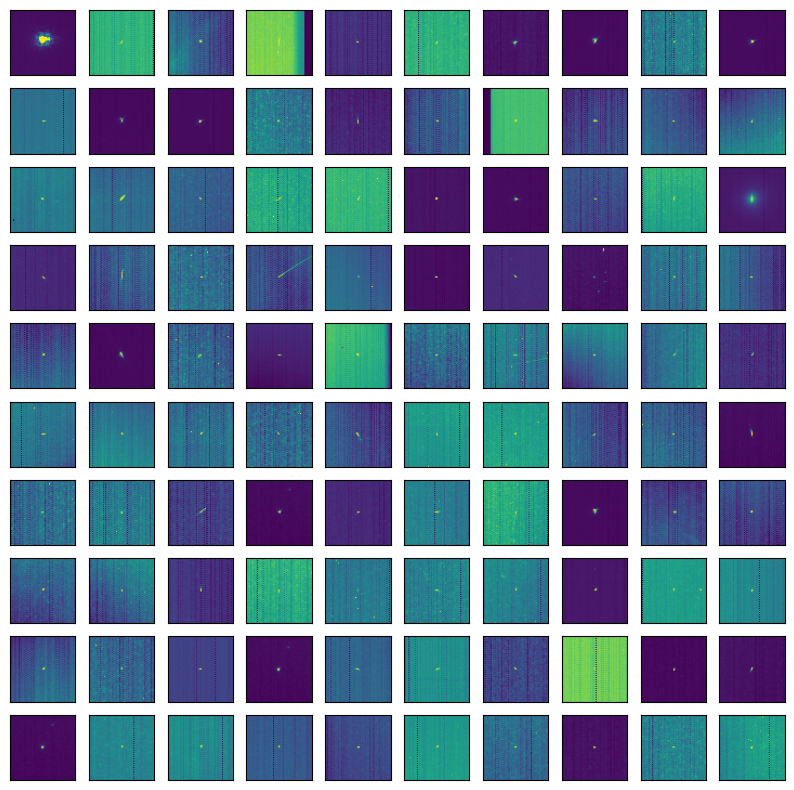

In [20]:
##### BRIGHT PIXELS WITH NO BACKGROUND ####
samples= objects.sample(100)
print(f"Number of samples in this class: {len(samples)}")

fig, axis = plt.subplots(10, 10, figsize = (10,10))
axis = axis.flatten()
for i in range(100):
    img = samples["REGION"].iloc[i]
    axis[i].set_xticks([]), axis[i].set_yticks([])
    axis[i].imshow(img)